## Урок 6. Feature Engineering, Feature Selection, part II

In [ ]:
# !pip install boostaroota
# !pip install shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import rankdata
from scipy.stats.mstats import winsorize
import warnings
import xgboost as xgb
from typing import List, Optional

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, roc_auc_score
import time
from datetime import datetime, date
from sklearn.inspection import permutation_importance
from boostaroota import BoostARoota
import shap
 
warnings.simplefilter("ignore")
%matplotlib inline

In [4]:
# from google.colab import drive
# drive.mount("/content/for_colab")
# !unzip "/content/for_colab/My Drive/for_colab/assignment2_data.zip" -d /content/data


Mounted at /content/for_colab
Archive:  /content/for_colab/My Drive/for_colab/assignment2_data.zip
  inflating: /content/data/assignment_2_test.csv  
  inflating: /content/data/assignment_2_train.csv  


Продолжим работу с данными, которые были использованы ранее, возмьмем за основу набор данных с дополнительными признаками, которые были созданы в предыдущем задании (оставить все признаки, вне зависимости от того, добавляют они качества или нет).

Задание 0: выбрать любимую модель и схему валидации решения, зафиксировать базовое качество модели.


In [5]:
train_data = pd.read_csv("data/assignment_2_train.csv")
test_data = pd.read_csv("data/assignment_2_test.csv")
train_data.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
test_data.head(n=2)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3287000,1,7415038,226.0,W,12473,555.0,150.0,visa,226.0,credit,299.0,87.0,116.0,NaN,aol.com,NaN,2.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,3.0,2.0,6.0,2.0,4.0,4.0,0.0,4.0,3.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,452.000000,2924.000000,2924.000000,0.0,412.0,0.0,412.0,206.0,412.0,412.0,452.0,2512.0,2512.0,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3287001,0,7415054,3072.0,W,15651,417.0,150.0,visa,226.0,debit,330.0,87.0,NaN,NaN,yahoo.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,0.0,0.0,1.0,3059.949951,3059.949951,3059.949951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3059.949951,3059.949951,3059.949951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print(train_data.shape, test_data.shape)

(180000, 394) (100001, 394)


In [8]:
le = LabelEncoder()
features_2 = ["card1", "card2", "card3", "card5", "addr1", "addr2"]
agr_card_addr_features = ["card_1_2", "card_1_2_3_5", "card_1_2_3_5_addr_1_2"]

def split_features(df):
    categorical_features = df.select_dtypes(include=[np.object]).columns
    numerical_features = list(set(df.columns) - set(categorical_features))
    return numerical_features, categorical_features

def create_stats_log(data: pd.DataFrame, 
                    feature: [str]) -> pd.DataFrame:
    
    stats = data.copy()
    stats["TransactionAmt_int"] = (stats["TransactionAmt"] // 1).astype(int)
    stats["TransactionAmt_frac"] = stats["TransactionAmt"] - stats["TransactionAmt_int"]
    stats["TransactionAmt_log"] = np.log(stats["TransactionAmt"])
    
    return stats

def create_stats(data: pd.DataFrame, 
                 groupby_col: List[str], 
                 stat: List[str],
                 feature: [str]) -> pd.DataFrame:
    
    stats = data[groupby_col]
    stats[feature] = data[feature]
    for gr_columns in groupby_col:
        data_grouped = data.groupby(gr_columns)
        for i in stat:
            columns = f"{feature}_{i}_{gr_columns}".upper()
            stats[columns] = data_grouped[feature].transform(i)
            columns_relationship = columns + "_relationship"
            stats[columns_relationship] = stats[feature] / stats[columns]

    stats = stats.drop(groupby_col, axis=1)
    stats = stats.drop(feature, axis=1)
    stats = stats.fillna(-9999)
    
    return stats

def data_from_lesson_5(train_df, test_df):
    data = pd.concat([train_df, test_df], axis=0)
    data = data.reset_index(drop=True)

    base_time_dt = time.mktime(date(2017, 12, 1).timetuple())
    # print(base_time_dt,"-", datetime.fromtimestamp(base_time_dt).strftime('%Y-%m-%d'))
    data["TransactionDT_date"] = pd.to_datetime(data.TransactionDT + base_time_dt, unit='s')
    data["TransactionDT_year"] = data["TransactionDT_date"].dt.year
    data["TransactionDT_month"] = data["TransactionDT_date"].dt.month
    data["TransactionDT_weekday"] = data["TransactionDT_date"].dt.weekday
    data["TransactionDT_hour"] = data["TransactionDT_date"].dt.hour
    data["TransactionDT_day"] = data["TransactionDT_date"].dt.day
    data = data.drop("TransactionDT_date", axis=1)

    data[features_2] = data[features_2].fillna(9)
    data["card_1_2"] = data["card1"].astype('str') + data["card2"].astype('str')
    data["card_1_2_3_5"] = data["card_1_2"] +  data["card3"].astype('str') + data["card5"].astype('str')
    data["card_1_2_3_5_addr_1_2"] = data["card_1_2_3_5"] + data["addr1"].astype('str') + data["addr2"].astype('str')

    data["card1freq_enc"]= data["card1"].map(data["card1"].value_counts(normalize=True))
    data["card2freq_enc"]= data["card2"].map(data["card2"].value_counts(normalize=True))
    data["card3freq_enc"]= data["card3"].map(data["card3"].value_counts(normalize=True))
    data["card5freq_enc"]= data["card5"].map(data["card5"].value_counts(normalize=True))
    data["addr1freq_enc"]= data["addr1"].map(data["addr1"].value_counts(normalize=True))
    data["addr2freq_enc"]= data["addr2"].map(data["addr2"].value_counts(normalize=True))

    data["card_1_2_freq_enc"]= data["card_1_2"].map(data["card_1_2"].value_counts(normalize=True))
    data["card_1_2_3_5_freq_enc"] = data["card_1_2_3_5"].map(data["card_1_2_3_5"].value_counts(normalize=True))
    data["card_1_2_3_5_addr_1_2_freq_enc"] = data["card_1_2_3_5_addr_1_2"].map(data["card_1_2_3_5_addr_1_2"].
                                                                                 value_counts(normalize=True))
    
    groupby_col = ["card1", "card2", "card3", "card5", "addr1", "addr2", "card_1_2", "card_1_2_3_5", "card_1_2_3_5_addr_1_2"] 
    stat = ["mean", "std"]
    stat_data_TAmt = create_stats(data, groupby_col=groupby_col, stat=stat, feature="TransactionAmt")
    stat_data_D15 = create_stats(data, groupby_col=groupby_col, stat=stat, feature="D15")
    stats_data_log = create_stats_log(data, "TransactionAmt")
    data[stat_data_TAmt.columns] = stat_data_TAmt
    data[stat_data_D15.columns] = stat_data_D15
    data[stats_data_log.columns] = stats_data_log

    categorical_features = split_features(data)[1]
    # print(categorical_features)
    for column in categorical_features:
        data[column] = data[column].replace(np.nan, 'none', regex=True)
        data[column] = le.fit_transform(data[column])

    # for column in data.columns:
    #     data[column] = data[column].fillna(-9999) 
    
    train_df, test_df = data[:180000], data[180000:]
    return train_df, test_df


In [9]:
train_df, test_df = data_from_lesson_5(train_data, test_data)
train_df.shape, test_df.shape

((180000, 486), (100001, 486))

In [10]:
train_df.head(n=20)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,TRANSACTIONAMT_STD_CARD_1_2_3_5_ADDR_1_2_relationship,D15_MEAN_CARD1,D15_MEAN_CARD1_relationship,D15_STD_CARD1,D15_STD_CARD1_relationship,D15_MEAN_CARD2,D15_MEAN_CARD2_relationship,D15_STD_CARD2,D15_STD_CARD2_relationship,D15_MEAN_CARD3,D15_MEAN_CARD3_relationship,D15_STD_CARD3,D15_STD_CARD3_relationship,D15_MEAN_CARD5,D15_MEAN_CARD5_relationship,D15_STD_CARD5,D15_STD_CARD5_relationship,D15_MEAN_ADDR1,D15_MEAN_ADDR1_relationship,D15_STD_ADDR1,D15_STD_ADDR1_relationship,D15_MEAN_ADDR2,D15_MEAN_ADDR2_relationship,D15_STD_ADDR2,D15_STD_ADDR2_relationship,D15_MEAN_CARD_1_2,D15_MEAN_CARD_1_2_relationship,D15_STD_CARD_1_2,D15_STD_CARD_1_2_relationship,D15_MEAN_CARD_1_2_3_5,D15_MEAN_CARD_1_2_3_5_relationship,D15_STD_CARD_1_2_3_5,D15_STD_CARD_1_2_3_5_relationship,D15_MEAN_CARD_1_2_3_5_ADDR_1_2,D15_MEAN_CARD_1_2_3_5_ADDR_1_2_relationship,D15_STD_CARD_1_2_3_5_ADDR_1_2,D15_STD_CARD_1_2_3_5_ADDR_1_2_relationship,TransactionAmt_int,TransactionAmt_frac,TransactionAmt_log
0,2987000,0,86400,68.500,4,13926,9.0,150.0,1,142.0,1,315.0,87.0,19.0,NaN,34,34,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999.000000,3.866667,0.000000,10.147953,0.000000,137.341994,0.000000,181.506756,0.000000,169.071464,0.000000,194.454596,0.000000,106.934066,0.000000,169.410140,0.000000,192.287981,0.000000,204.842587,0.000000,170.162992,0.000000,194.610981,0.000000,0.500000,0.000000,0.577350,0.000000,0.500000,0.000000,0.577350,0.000000,0.000000,-9999.000000,-9999.000000,-9999.000000,68,0.500,4.226834
1,2987001,0,86401,29.000,4,2755,404.0,150.0,2,102.0,1,325.0,87.0,NaN,NaN,16,34,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.037691,127.908772,0.000000,184.973710,0.000000,138.362441,0.000000,185.462955,0.000000,169.071464,0.000000,194.454596,0.000000,115.791266,0.000000,178.492744,0.000000,191.837859,0.000000,201.730856,0.000000,170.162992,0.000000,194.610981,0.000000,128.666667,0.000000,185.657269,0.000000,128.666667,0.000000,185.657269,0.000000,86.612903,0.000000,117.658171,0.000000,29,0.000,3.367296
2,2987002,0,86469,59.000,4,4663,490.0,150.0,4,166.0,2,330.0,87.0,287.0,NaN,36,34,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,4.234311,114.748284,2.745139,166.484470,1.892068,186.886432,1.685516,200.670841,1.569735,169.071464,1.863117,194.454596,1.619915,128.663077,2.448255,170.523998,1.847247,180.500353,1.745149,199.068411,1.582371,170.162992,1.851166,194.610981,1.618614,115.066820,2.737540,166.822990,1.888229,115.066820,2.737540,166.822990,1.888229,58.812500,5.356004,124.244500,2.535323,59,0.000,4.077537
3,2987003,0,86499,50.000,4,18132,567.0,150.0,2,117.0,2,476.0,87.0,NaN,NaN,54,34,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.178052,188.179548,0.589862,200.587961,0.553373,177.997436,0.623604,197.497789,0.562032,169.071464,0.656527,194.454596,0.570827,181.120683,0.612851,199.225906,0.557156,152.921082,0.725865,184.037418,0.603138,170.162992,0.652316,194.610981,0.570369,187.835224,0.590943,200.388089,0.553925,187.835224,0.590943,200.388089,0.553925,167.724138,0.661801,141.582398,0.783996,50,0.000,3.912023
4,2987004,0,86506,50.000,1,4497,514.0,150.0,2,102.0,1,420.0,87.0,NaN,NaN,16,34,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9999.000000,4.750000,-9999.000000,6.184658,-9999.000000,162.303592,-9999.000000,198.166385,-9999.000000,169.071464,-9999.000000,194.454596,-9999.000000,115.791266,-9999.000000,178.492744,-9999.000000,171.067308,-9999.000000,191.358484,-9999.000000,170.162992,-9999.000000,194.610981,-9999.000000,4.750000,-9999.000000,6.184658,-9999.000000,4.750000,-9999.000000,6.18

In [11]:
split_features(train_df)[1]

Index([], dtype='object')

In [12]:
numerical_features = split_features(train_df)[0]

In [13]:
x_train, x_valid = train_test_split(
    train_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.60, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    train_df["isFraud"], train_size=0.60, shuffle=True, random_state=1,
)

x_test = (test_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_test = test_df["isFraud"]

In [14]:
numerical_features = split_features(x_train)[0]

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
# print(len(numerical_features))

x_train.shape = 108000 rows, 483 cols
x_valid.shape = 72000 rows, 483 cols
x_test.shape = 100001 rows, 483 cols


In [15]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [16]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [17]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.652059	test-auc:0.622476
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.753557	test-auc:0.705839
[20]	train-auc:0.831002	test-auc:0.785159
[30]	train-auc:0.866011	test-auc:0.839847
[40]	train-auc:0.879998	test-auc:0.85081
[50]	train-auc:0.891595	test-auc:0.857809
[60]	train-auc:0.897975	test-auc:0.861198
[70]	train-auc:0.904153	test-auc:0.862038
[80]	train-auc:0.909009	test-auc:0.863604
[90]	train-auc:0.912344	test-auc:0.864939
[100]	train-auc:0.915351	test-auc:0.865605
[110]	train-auc:0.917891	test-auc:0.865709
[120]	train-auc:0.91962	test-auc:0.86613
[130]	train-auc:0.921485	test-auc:0.866794
[140]	train-auc:0.923109	test-auc:0.867695
[150]	train-auc:0.924347	test-auc:0.868143
[160]	train-auc:0.925686	test-auc:0.867859
[170]	train-auc:0.926031	test-auc:0.86784
Stopping. Best iteration:
[149]	train-auc:0.924269	test-auc:0.868199



In [18]:
train_roc_auc_score_0 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_0 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_0 = roc_auc_score(y_test, model.predict(dtest))

In [19]:
print('train: %.4f' % train_roc_auc_score_0)
print('valid: %.4f' % valid_roc_auc_score_0)
print('test: %.4f' % test_roc_auc_score_0)

train: 0.9260
valid: 0.9059
test: 0.8678


Задание 1: использовать внутренний способ для оценки важности признаков алгоритма, вывести его в виде диаграммы.


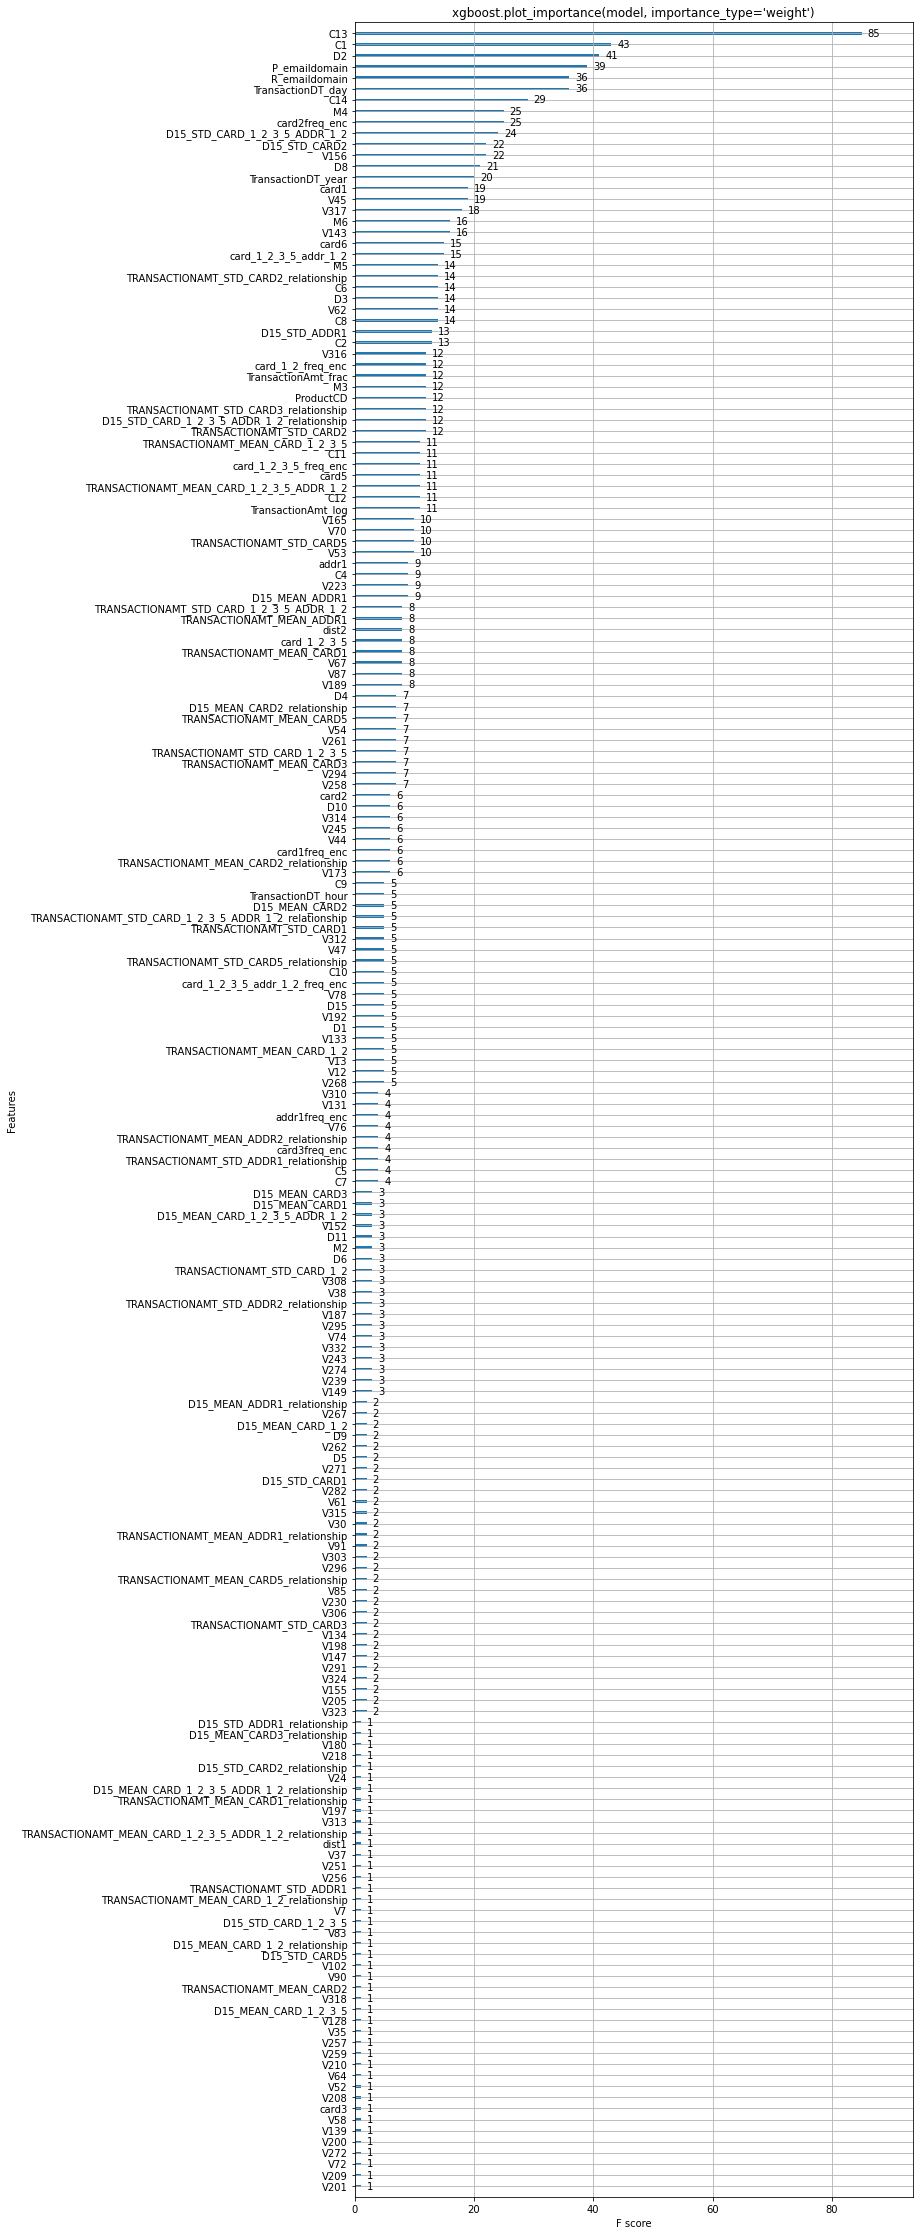

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(10, 40))

xgb.plot_importance(model, ax=ax)
ax.set_title("xgboost.plot_importance(model, importance_type='weight')")

# xgb.plot_importance(model, ax=ax[1], importance_type="cover")
# ax[1].set_title("xgboost.plot_importance(model, importance_type='cover')")

# xgb.plot_importance(model, ax=ax[2], importance_type="gain")
# ax[2].set_title("xgboost.plot_importance(model, importance_type='gain')")
plt.show()

Задание 2: удалить признаки с нулевой или маленькой важностью, переобучить модель и оценить изменение качества.


In [21]:
yticklabels = ax.get_yticklabels()[::-1]
topn_features = []

In [22]:
for i in range(len(yticklabels)):
    topn_features.append(yticklabels[i].get_text())

len(topn_features)

196

In [23]:
x_train, x_valid = train_test_split(
    train_df[topn_features], train_size=0.60, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    train_df["isFraud"], train_size=0.60, shuffle=True, random_state=1,
)

x_test = test_df[topn_features]
y_test = test_df["isFraud"]

In [24]:
x_train = x_train[topn_features]
x_valid = x_valid[topn_features]
x_test = x_test[topn_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 196 cols
x_valid.shape = 72000 rows, 196 cols
x_test.shape = 100001 rows, 196 cols


In [25]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [26]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [27]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.652059	test-auc:0.622476
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.753557	test-auc:0.705839
[20]	train-auc:0.831002	test-auc:0.785156
[30]	train-auc:0.866011	test-auc:0.839842
[40]	train-auc:0.879998	test-auc:0.850808
[50]	train-auc:0.891595	test-auc:0.857811
[60]	train-auc:0.897975	test-auc:0.861202
[70]	train-auc:0.904153	test-auc:0.86204
[80]	train-auc:0.909009	test-auc:0.863607
[90]	train-auc:0.912344	test-auc:0.864942
[100]	train-auc:0.915351	test-auc:0.865609
[110]	train-auc:0.917891	test-auc:0.865714
[120]	train-auc:0.91962	test-auc:0.866135
[130]	train-auc:0.921485	test-auc:0.866798
[140]	train-auc:0.923109	test-auc:0.867699
[150]	train-auc:0.924347	test-auc:0.868147
[160]	train-auc:0.925686	test-auc:0.867863
[170]	train-auc:0.926031	test-auc:0.867844
Stopping. Best iteration:
[149]	train-auc:0.924269	test-auc:0.868203



In [28]:
train_roc_auc_score_2 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_2 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_2 = roc_auc_score(y_test, model.predict(dtest))

In [29]:
print('train: %.4f' % train_roc_auc_score_2)
print('valid: %.4f' % valid_roc_auc_score_2)
print('test: %.4f' % test_roc_auc_score_2)

train: 0.9260
valid: 0.9059
test: 0.8678


Результат одинаковый. Я перепроверил несколько раз, ошибки не нашел. Может сама модель игнорирует признаки с нулевой или маленькой важностью? 

Задание 3: использовать permutation importance, выполнить задание 1 и 2.


In [31]:
x_train, x_valid = train_test_split(
    train_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.60, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    train_df["isFraud"], train_size=0.60, shuffle=True, random_state=1,
)

x_test = (test_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_test = test_df["isFraud"]

In [32]:
numerical_features = split_features(x_train)[0]

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 483 cols
x_valid.shape = 72000 rows, 483 cols
x_test.shape = 100001 rows, 483 cols


In [33]:
model_ = xgb.XGBClassifier(max_depth=2, n_estimators=10)
model_.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=10, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [34]:
importance = permutation_importance(
    model_, x_valid, y_valid, scoring="roc_auc", n_jobs=6, random_state=27
)

In [35]:
importance_scores = pd.DataFrame({
    "features": x_valid.columns,
    "importance-mean": importance.importances_mean,
    "importance-std": importance.importances_std,
})
importance_scores = importance_scores.sort_values(
    by="importance-mean", ascending=False
)
importance_scores = importance_scores.reset_index(drop=True)
decrease_scores = importance_scores[importance_scores["importance-mean"]<=0]
decrease_scores = decrease_scores.reset_index(drop=True)

In [36]:
decrease_features = decrease_scores["features"].tolist()

In [37]:
x_train, x_valid = train_test_split(
    train_df[decrease_features], train_size=0.60, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    train_df["isFraud"], train_size=0.60, shuffle=True, random_state=1,
)

x_test = test_df[decrease_features]
y_test = test_df["isFraud"]

In [38]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 470 cols
x_valid.shape = 72000 rows, 470 cols
x_test.shape = 100001 rows, 470 cols


In [39]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [40]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [41]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.630737	test-auc:0.61449
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.754274	test-auc:0.701714
[20]	train-auc:0.824397	test-auc:0.781148
[30]	train-auc:0.864625	test-auc:0.842306
[40]	train-auc:0.880426	test-auc:0.853538
[50]	train-auc:0.889625	test-auc:0.858118
[60]	train-auc:0.896243	test-auc:0.860349
[70]	train-auc:0.903175	test-auc:0.861248
[80]	train-auc:0.908119	test-auc:0.863969
[90]	train-auc:0.911525	test-auc:0.864709
[100]	train-auc:0.914498	test-auc:0.866005
[110]	train-auc:0.916745	test-auc:0.866429
[120]	train-auc:0.918589	test-auc:0.866713
[130]	train-auc:0.920487	test-auc:0.86685
[140]	train-auc:0.922917	test-auc:0.867582
[150]	train-auc:0.924171	test-auc:0.86802
[160]	train-auc:0.924236	test-auc:0.868148
[170]	train-auc:0.924236	test-auc:0.868148
Stopping. Best iteration:
[151]	train-auc:0.924236	test-auc:0.868148



In [42]:
train_roc_auc_score_0 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_0 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_0 = roc_auc_score(y_test, model.predict(dtest))

In [43]:
print('train: %.4f' % train_roc_auc_score_0)
print('valid: %.4f' % valid_roc_auc_score_0)
print('test: %.4f' % test_roc_auc_score_0)

train: 0.9242
valid: 0.9048
test: 0.8681


Задание 4: использовать BoostARoota для отбора признаков (настраивать или нет - на ваше усмотрение), переобучить модель и оценить изменение качества.


In [44]:
def prepare_data(X: pd.DataFrame) -> pd.DataFrame:
    """
    Подготовка набора данных для моделирования.
    Категориальные признаки преобразуются с помощью
    OneHotEnconding.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Преобразованная матрица признаков.

    """
    categorical = X.dtypes[X.dtypes=="object"].index.tolist()

    X = pd.get_dummies(X, columns=categorical)
    X.columns = [col.lower() for col in X.columns]
    
    return X

In [45]:
train_BAR_df = prepare_data(train_df)
test_BAR_df = prepare_data(test_df)

In [46]:
x_train, x_valid = train_test_split(
    train_BAR_df.drop(["transactionid", "transactiondt", "isfraud"], axis=1), train_size=0.60, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    train_BAR_df["isfraud"], train_size=0.60, shuffle=True, random_state=1,
)

x_test = (test_BAR_df.drop(["transactionid", "transactiondt", "isfraud"], axis=1))
y_test = test_BAR_df["isfraud"]

In [47]:
br = BoostARoota(metric='auc')
br.fit(x_train, y_train)

Round:  1  iteration:  1
Round:  1  iteration:  2
Round:  1  iteration:  3
Round:  1  iteration:  4
Round:  1  iteration:  5
Round:  1  iteration:  6
Round:  1  iteration:  7
Round:  1  iteration:  8
Round:  1  iteration:  9
Round:  1  iteration:  10
Round:  2  iteration:  1
Round:  2  iteration:  2
Round:  2  iteration:  3
Round:  2  iteration:  4
Round:  2  iteration:  5
Round:  2  iteration:  6
Round:  2  iteration:  7
Round:  2  iteration:  8
Round:  2  iteration:  9
Round:  2  iteration:  10
BoostARoota ran successfully! Algorithm went through  2  rounds.


In [48]:
br.keep_vars_

0                                   transactionamt
1                                        productcd
2                                            card1
3                                            card2
4                                            card3
                          ...                     
315                 d15_mean_card_1_2_3_5_addr_1_2
316    d15_mean_card_1_2_3_5_addr_1_2_relationship
317                  d15_std_card_1_2_3_5_addr_1_2
318     d15_std_card_1_2_3_5_addr_1_2_relationship
319                            transactionamt_frac
Name: feature, Length: 290, dtype: object

In [49]:
x_train_br = br.transform(x_train)
x_valid_br = br.transform(x_valid)
x_test_br = br.transform(x_test)

dtrain_br = xgb.DMatrix(x_train_br, label=y_train)
dvalid_br = xgb.DMatrix(x_valid_br, label=y_valid)
dtest_br = xgb.DMatrix(x_test_br, label=y_test)

In [50]:
print("x_train_br.shape = {} rows, {} cols".format(*x_train_br.shape))
print("x_valid_br.shape = {} rows, {} cols".format(*x_valid_br.shape))
print("x_test_br.shape = {} rows, {} cols".format(*x_test_br.shape))

x_train_br.shape = 108000 rows, 290 cols
x_valid_br.shape = 72000 rows, 290 cols
x_test_br.shape = 100001 rows, 290 cols


In [51]:
model_br = xgb.train(
    params,
    dtrain_br,
    num_boost_round=5000,
    evals=[(dtrain_br, "train"), (dvalid_br, "valid")],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-auc:0.652059	valid-auc:0.648306
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 50 rounds.
[100]	train-auc:0.91353	valid-auc:0.89703
Stopping. Best iteration:
[136]	train-auc:0.920998	valid-auc:0.902855



In [52]:
old_preds = model.predict(dvalid)
new_preds = model_br.predict(dvalid_br)

old_score = roc_auc_score(y_valid, old_preds)
new_score = roc_auc_score(y_valid, new_preds)
print(f"Base XGBoost score = {round(old_score, 5)}")
print(f"Base BoostARoota score = {round(new_score, 5)}")

Base XGBoost score = 0.90477
Base BoostARoota score = 0.90286


Задание 5: использовать shap, выполнить задание 1 и 2.


In [53]:
x_train, x_valid = train_test_split(
    train_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.60, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    train_df["isFraud"], train_size=0.60, shuffle=True, random_state=1,
)

x_test = (test_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_test = test_df["isFraud"]

In [54]:
numerical_features = split_features(x_train)[0]

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 483 cols
x_valid.shape = 72000 rows, 483 cols
x_test.shape = 100001 rows, 483 cols


In [75]:
model = xgb.XGBClassifier(**params)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=100, scale_pos_weight=1, seed=27,
              silent=None, subsample=1, verbosity=1)

In [56]:
# x_valid_, y_valid_ = x_valid.sample(2000), y_valid.sample(2000)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid, y_valid)

In [57]:
shap.initjs()

shap.force_plot(
    explainer.expected_value, shap_values[0,:], x_valid.iloc[0,:], link="logit"
)

In [58]:
# shap.force_plot(explainer.expected_value, shap_values, features=x_valid) 

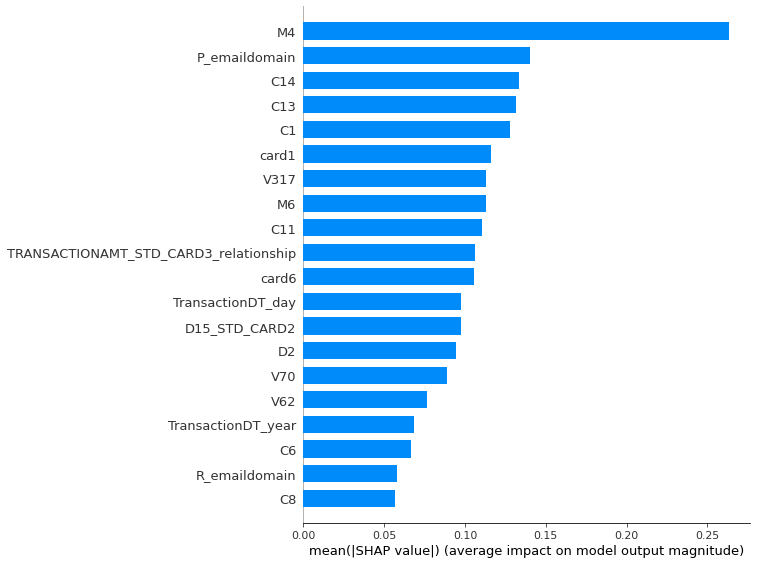

In [59]:
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=20)

In [79]:
shap_importance = list(zip(x_valid.columns, np.abs(shap_values).mean(0)))
shap_importance = pd.DataFrame(shap_importance, columns=['feature','shap_importance'])
shap_importance.sort_values(by=['shap_importance'],ascending=False,inplace=True)
shap_importance.head(n=5)

,feature,shap_importance
110,M4,0.263168
427,P_emaildomain,0.140183
457,C14,0.133556
450,C13,0.131325
22,C1,0.127650


In [115]:
shap_importance = shap_importance.dropna()
shap_importance.where(shap_importance["shap_importance"]>0)
shap_importance_features = shap_importance["feature"].tolist()
len(shap_importance_features)

196

In [117]:
x_train, x_valid = train_test_split(
    train_df[shap_importance_features], train_size=0.60, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    train_df["isFraud"], train_size=0.60, shuffle=True, random_state=1,
)

x_test = test_df[shap_importance_features]
y_test = test_df["isFraud"]

In [118]:
print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 196 cols
x_valid.shape = 72000 rows, 196 cols
x_test.shape = 100001 rows, 196 cols


In [121]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dvalid = xgb.DMatrix(data=x_valid, label=y_valid)
dtest = xgb.DMatrix(data=x_test, label=y_test)

In [122]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 1000,
    "reg_lambda": 100,
    "max_depth": 4,
    "gamma": 10,
    "nthread": 6,
    "seed": 27
}

In [123]:
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    early_stopping_rounds=25,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10,
    maximize=True,
)

[0]	train-auc:0.652059	test-auc:0.622476
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 25 rounds.
[10]	train-auc:0.753557	test-auc:0.705839
[20]	train-auc:0.831002	test-auc:0.785156
[30]	train-auc:0.866011	test-auc:0.839841
[40]	train-auc:0.879998	test-auc:0.850807
[50]	train-auc:0.891595	test-auc:0.85781
[60]	train-auc:0.897975	test-auc:0.861201
[70]	train-auc:0.904153	test-auc:0.862039
[80]	train-auc:0.909009	test-auc:0.863606
[90]	train-auc:0.912344	test-auc:0.864941
[100]	train-auc:0.915351	test-auc:0.865608
[110]	train-auc:0.917891	test-auc:0.865713
[120]	train-auc:0.91962	test-auc:0.866134
[130]	train-auc:0.921485	test-auc:0.866798
[140]	train-auc:0.923109	test-auc:0.867698
[150]	train-auc:0.924347	test-auc:0.868146
[160]	train-auc:0.925686	test-auc:0.867863
[170]	train-auc:0.926031	test-auc:0.867843
Stopping. Best iteration:
[149]	train-auc:0.924269	test-auc:0.868202



In [124]:
train_roc_auc_score_0 = roc_auc_score(y_train, model.predict(dtrain))
valid_roc_auc_score_0 = roc_auc_score(y_valid, model.predict(dvalid))
test_roc_auc_score_0 = roc_auc_score(y_test, model.predict(dtest))

In [125]:
print('train: %.4f' % train_roc_auc_score_0)
print('valid: %.4f' % valid_roc_auc_score_0)
print('test: %.4f' % test_roc_auc_score_0)

train: 0.9260
valid: 0.9059
test: 0.8678


Задание 6: построить shap.summary_plot и shap.decision_plot для небольшой группы примеров (определить размер самостоятельно) и проанализировать влияние признаков на поведение модели.

In [127]:
x_train, x_valid = train_test_split(
    train_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1), train_size=0.60, shuffle=True, random_state=1,
)
y_train, y_valid = train_test_split(
    train_df["isFraud"], train_size=0.60, shuffle=True, random_state=1,
)

x_test = (test_df.drop(["TransactionID", "TransactionDT", "isFraud"], axis=1))
y_test = test_df["isFraud"]

In [128]:
numerical_features = split_features(x_train)[0]

x_train = x_train[numerical_features]
x_valid = x_valid[numerical_features]
x_test = x_test[numerical_features]

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 108000 rows, 483 cols
x_valid.shape = 72000 rows, 483 cols
x_test.shape = 100001 rows, 483 cols


In [129]:
model = xgb.XGBClassifier(**params)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=10, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=100, scale_pos_weight=1, seed=27,
              silent=None, subsample=1, verbosity=1)

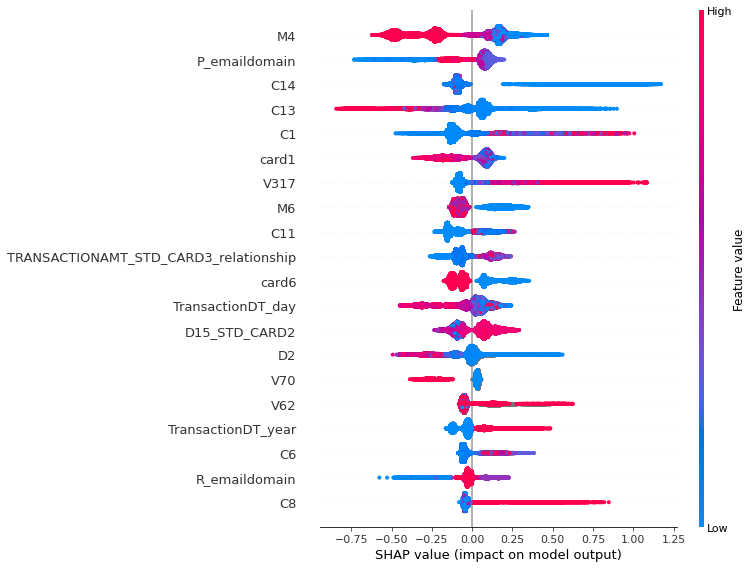

In [130]:
shap.summary_plot(shap_values, x_valid)

In [131]:
explainer = shap.TreeExplainer(model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = x_valid.iloc[select]
features_display = x_valid.loc[features.index]
shap_values = explainer.shap_values(features)
shap_interaction_values = explainer.shap_interaction_values(features)

if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]

Explainer expected value: [-3.71748638]


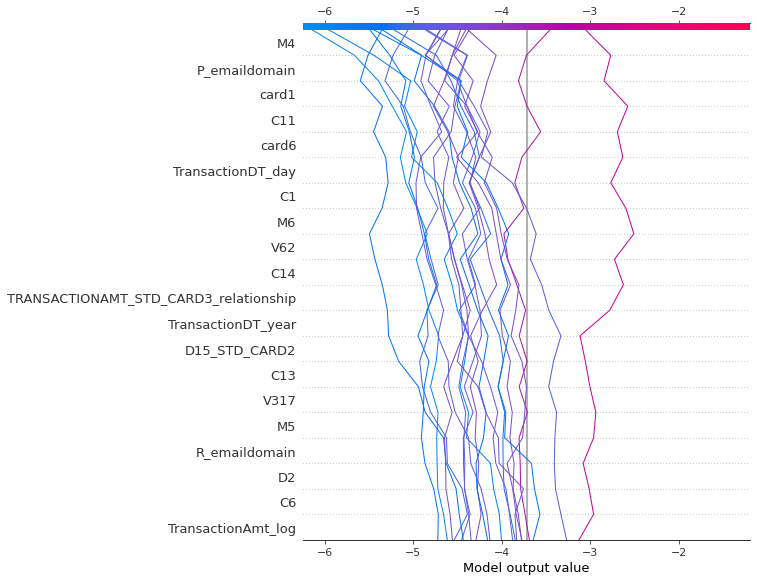

In [132]:
shap.decision_plot(
    expected_value, shap_values, features_display.iloc[:20]
)

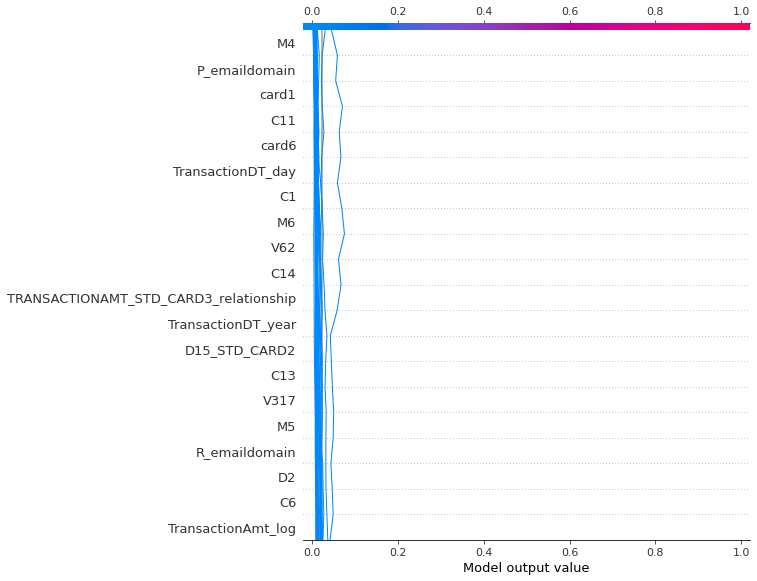

In [133]:
shap.decision_plot(expected_value, shap_values, features_display.iloc[:20], link="logit")

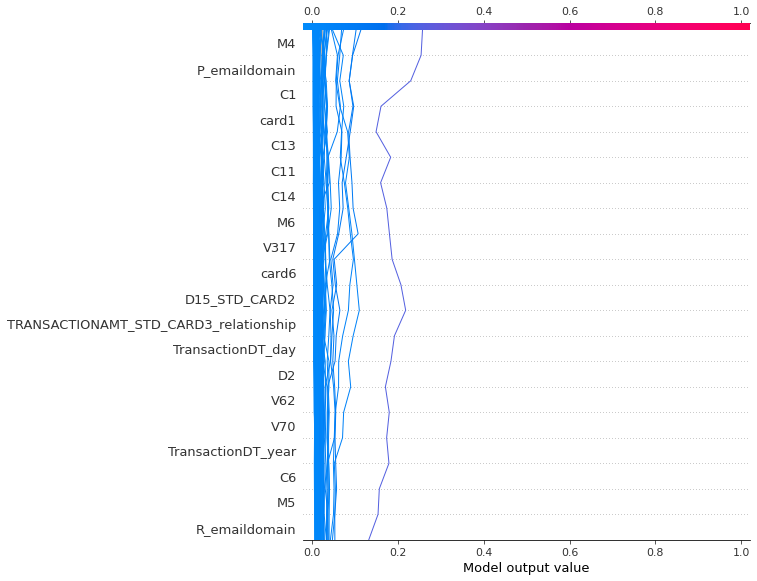

In [134]:
shap_values = explainer.shap_values(x_valid, y_valid)
y_pred = (shap_values.sum(1) + expected_value) > 0

misclassified = y_pred != y_valid
shap.decision_plot(
    expected_value, shap_values[:100], features_display.iloc[:100], link='logit', highlight=misclassified[:100]
)